In [83]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

directory='/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc04/rr1/1024x1448x512/'
# directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat']


0.4: [0.204424113258,0.0157266721391],
0.4: [0.291010225832,0.0536405799315],
0.4: [0.309015471478,0.0483437307288],


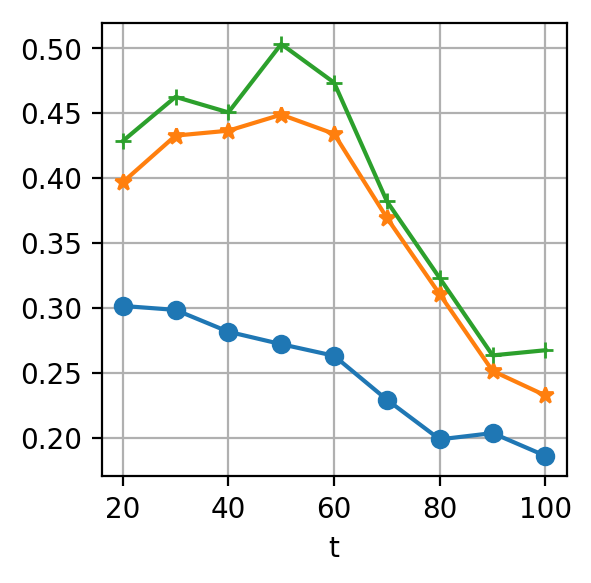

In [85]:
flist = glob.glob(directory+"*lscale_vv*")
t = np.zeros(len(flist))
ly = np.zeros([len(flist),3])

for i,fname in enumerate(flist):
    tID = fname.split('_')[-1]
    tID = int(tID.split('.dat')[0])
    t[i] = nml.read_time(directory,tID)

    # Get eta
    dtheta = get_dtheta(directory,t[i])
    
    # Get L99
    utilde = np.fromfile(directory+'shearlayer_utilde_%04d.dat'%tID,sep=' ')
    L99,tmp1,tmp2 = get_L99(-y,utilde)
    
    # Get ly/L99
    autocorr = np.fromfile(fname,sep=' ')
    autocorr = np.reshape(autocorr,[Ny,3])
    ly[i,0],tmp1,tmp2 = get_lscale(y,autocorr[:,0],thresh=0.2)/L99
    ly[i,1],tmp1,tmp2 = get_lscale(y,autocorr[:,1],thresh=0.2)/L99
    ly[i,2],tmp1,tmp2 = get_lscale(y,autocorr[:,2],thresh=0.2)/L99

isort = np.argsort(t)
t = t[isort]
ly = ly[isort,:]

plt.figure(figsize=(3,3),dpi=200)
plt.plot(t,ly[:,0],'-o')
plt.plot(t,ly[:,1],'-*')
plt.plot(t,ly[:,2],'-+')
plt.xlabel('t')
plt.grid(True)

istart = -4
iend = None
for i in range(3):
    print('{}: [{},{}],'.format(inp.Mc,np.mean(ly[istart:iend,i]),np.std(ly[istart:iend,i])))


In [86]:
mid = {
    0.2: [0.302258391239,0.0165258852098],
    0.4: [0.204424113258,0.0157266721391],
    0.8: [0.152719324517,0.00524371634072],
    1.2: [0.127626113102,0.0108050933647],
    1.6: [0.114818177122,0.00695265207051],
    2.0: [0.0986508035738,0.00766210147441],
}
top = {
    0.2: [0.400517010571,0.0269137399722],
    0.4: [0.291010225832,0.0536405799315],
    0.8: [0.197650622964,0.0184227372718],
    1.2: [0.165485973003,0.0154454899296],
    1.6: [0.129250565271,0.0111207436125],
    2.0: [0.127870573686,0.00997168365225],
}
bot = {
    0.2: [0.408269996823,0.0223557431386],
    0.4: [0.309015471478,0.0483437307288],
    0.8: [0.198282496745,0.0162659743436],
    1.2: [0.15843926392,0.00516070248174],
    1.6: [0.134218566606,0.00887590169742],
    2.0: [0.107826091843,0.0116364813684],
}

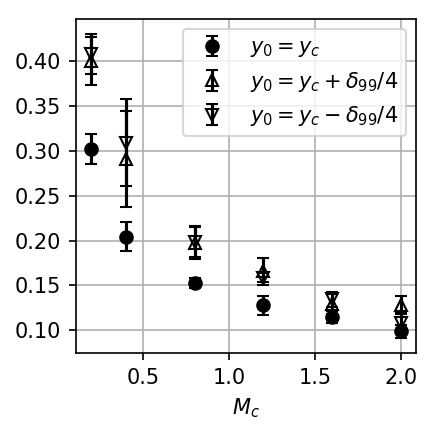

In [87]:

def plotter(dat,label,fmt,fillstyle='full'):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,fillstyle=fillstyle,label=label,capsize=3)

    
fig = plt.figure(figsize=(3,3),dpi=150)
plotter(mid,r'$y_0=y_c$','ko')
plotter(top,r'$y_0=y_c+\delta_{99}/4$','k^',fillstyle='none')
plotter(bot,r'$y_0=y_c-\delta_{99}/4$','kv',fillstyle='none')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.tight_layout()
plt.legend()